# Orbital Traction SentinAL Testing
---
Test Dates: March 6 - , 2023  

Written By: Joel McClurkin  
Date: March 1, 2023  

# Objective  

Request was emailed from Scott Payne:  
>
>From: Scott Payne <scott.payne@orbitaltraction.com>Date: Tuesday, February 28, 2023 at 10:47 AMTo: Joel McClurkin <joel.mcclurkin@outlook.com>Cc: Stuart Schaaf <stuart.schaaf@intersyn.com>, Pat Bixenman <pat.bixenman@orbitaltraction.com>, Jordan Hanson <jordan.hanson@orbitaltraction.com>, Chris Sanchez <chris.sanchez@orbitaltraction.com>, Jeff Gorley <Jeff.Gorley@orbitaltraction.com>  
>
>Subject: RE: Sprocket configuration suitable for 3 – 8 SPM pump speed  
>
>Joel,  
> 
>Correction: RPU 1.5 configuration for TTU (140 tooth jackshaft sprocket for 3.889 ratio)  
>	•	3.5 – 8.0 SPM with 9 inch sheave --- primary  
>	•	2.5 – 5.5 SPM with 6 inch sheave --- backup  
> 
>For these two configurations above, please estimate the average (and peak?) power(s) [HP] to operate 2.5 SPM to 8.0 SPM.  
>	•	Output motor shaft  
>	•	Input motor  
>	•	Input to soft start  
> 
>Provide a table or similar to convey with 0.5 SPM increments.  
>   
>Also, could you provide a nominal/typical cyclic torque profile at the 6 inch sheave as a function of crank angle?  
>
>Best regards,  
>Scott
>

This notebook will:
1. Read in processed test data (resampled)
2. Use previously developed ML model to predict input torque
3. Use input torque to recalculate powers
4. Output results to CSV files

In [1]:
# import pacakges and libraries
import os
import sys
import numpy as np
import pandas as pd
import xlwings as xw
from datetime import datetime
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.ticker as ticker

from sklearn.preprocessing import PolynomialFeatures
from joblib import load


In [2]:
# insert the path that contains the functions and RPU geometry definitions
sys.path.insert(1,"/Users/joel/github_repositories/OrbitalTraction/" \
                +"RPU_Tests_2022/Field_Testing_TTU/01_Data_Processing")

In [3]:
# import the RPU configuration dimensions and properties
from RPU_Config_Variables import *
import Data_Proc_Fcns as dpf
from Thirty_HP_NEMA_D_config import *

/Users/joel/github_repositories/OrbitalTraction/RPU_Tests_2022/Field_Testing_TTU/01_Data_Processing/Thirty_HP_NEMA_D_config.py:41: RuntimeWarning: invalid value encountered in double_scalars
  eff_v_output_data["power_in"] = [p / e for p,e in zip(eff_v_output_data["power"], eff_v_output_data["efficiency"])]


## Variables Specific to this Series of Tests

In [4]:
# define variables unique to this test

Test_Name = "2023 RPU1-5 Predict"

Test_Date = datetime(2023,3,1)

# set directory for reading Rapidlogger raw data
Data_Path = "/Users/joel/Library/CloudStorage/OneDrive-Personal/McClurkin Consulting/"\
    +"Orbital Traction/Rod Pump Unit Project/Data/RPU_Processed_Data_2022/TTU_Data/Series E'/"

Model_Path = "/Users/joel/Library/CloudStorage/OneDrive-Personal/McClurkin Consulting/"\
    +"Orbital Traction/Rod Pump Unit Project/Data/RPU_Processed_Data_2022/Lab_Data/Models/"

# set directory for writing processed data to
Write_Path = "/Users/joel/Library/CloudStorage/OneDrive-Personal/McClurkin Consulting/"\
    +"Orbital Traction/Rod Pump Unit Project/Data/RPU_Processed_Data_2023/"


## Read Data Files

## Test Series and Data Files
Will be using data from Series E4 Test Data - All.csv  
Series E4 data has the Polished Rod load derived from the Dyne Card.  

In [5]:
df_Data = pd.read_csv(Data_Path + "Series E4 Test Data - All.csv", \
    parse_dates=["ClockTime","Date"], index_col=0)

df_Data["Date"] = Test_Date

In [6]:
df_Data

,ClockTime,AcqTime,SPM Bin,StrokeNum,PM Sheave Dia,Date,Angle,PM RPM,CVTSpeedIn,CVTSpeedOut,...,Motor Output Power,Motor Output Energy,Motor Input Power No Regen,Motor Input Energy No Regen,Motor Output Power No Regen,Motor Output Energy No Regen,PR Energy,PR Power,DC Load,PR Load
0,2022-09-08 08:51:25.802426001,31885.802426,NaN,0,6,2023-03-01,357.300777,27.368544,67.954896,160.25816,...,7.575262,0.078980,9.091859,0.094792,7.575262,0.078980,0.000948,0.090915,6189.000000,6189.000000
1,2022-09-08 08:51:25.808000000,31885.808000,NaN,0,6,2023-03-01,357.360000,42.000000,69.000000,162.00000,...,7.560379,0.042142,9.075508,0.050587,7.560379,0.042142,0.000507,0.090912,6189.000000,6189.000000
2,2022-09-08 08:51:25.817444001,31885.817444,NaN,0,6,2023-03-01,357.306877,42.590256,70.770768,164.95128,...,7.638181,0.072135,9.160970,0.086516,7.638181,0.072135,0.000876,0.092809,6189.000000,6189.000000
3,2022-09-08 08:51:25.824000000,31885.824000,NaN,0,6,2023-03-01,357.270000,43.000000,72.000000,167.00000,...,7.692201,0.050430,9.220292,0.060448,7.692201,0.050430,0.000608,0.092807,6189.000000,6189.000000
4,2022-09-08 08:51:25.832421001,31885.832421,NaN,0,6,2023-03-01,357.270000,44.052640,74.105280,170.15792,...,7.700560,0.064846,9.229469,0.077721,7.700560,0.064846,0.000686,0.081445,6189.000000,6189.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669208,2022-09-08 17:33:28.164444001,63208.164444,"(0.75, 1.25]",1648,6,2023-03-01,358.150000,122.000000,0.000000,0.00000,...,-0.338970,-0.001506,0.000000,0.000000,-0.475998,-0.002115,0.000234,0.052583,6608.569416,6608.569416
2669209,2022-09-08 17:33:28.176000000,63208.176000,"(0.75, 1.25]",1648,6,2023-03-01,358.150000,122.000000,0.000000,0.00000,...,-0.338970,-0.003917,0.000000,0.000000,-0.475998,-0.005501,0.000608,0.052576,6607.531069,6607.531069
2669210,2022-09-08 17:33:28.179420001,63208.179420,"(0.75, 1.25]",1648,6,2023-03-01,358.150000,122.000000,0.000000,0.00000,...,-0.338970,-0.001159,0.000000,0.000000,-0.475998,-0.001628,0.000311,0.090985,6606.916493,6606.916493
2669211,2022-09-08 17:33:28.192000000,63208.192000,"(0.75, 1.25]",1648,6,2023-03-01,358.150000,122.000000,0.000000,0.00000,...,-0.338970,-0.004264,0.000000,0.000000,-0.475998,-0.005988,0.001144,0.090957,6604.655780,6604.655780


In [7]:
df_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2669213 entries, 0 to 2669212
Data columns (total 62 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   ClockTime                     datetime64[ns]
 1   AcqTime                       float64       
 2   SPM Bin                       object        
 3   StrokeNum                     int64         
 4   PM Sheave Dia                 int64         
 5   Date                          datetime64[ns]
 6   Angle                         float64       
 7   PM RPM                        float64       
 8   CVTSpeedIn                    float64       
 9   CVTSpeedOut                   float64       
 10  TorqueTransducer              float64       
 11  OpticalSpeedSensor            float64       
 12  VoltageL1L2                   float64       
 13  VoltageL2L3                   float64       
 14  VoltageL3L1                   float64       
 15  CurrentPhaseL1                fl

### Resample Data
Resample the data if necessary.

In [8]:
# any column that is not a float will not be resampled
excl_cols = [c for c in list(df_Data.columns) if df_Data[c].dtype != float]

SPM_cols = [c for c in excl_cols if c != "ClockTime"]

# resample the rest of the columns
resamp_cols = [c for c in list(df_Data.columns) if c not in excl_cols]

In [9]:
SPM_cols

['SPM Bin', 'StrokeNum', 'PM Sheave Dia', 'Date']

In [10]:
# resample the data at 10Hz
df_Data_Resamp = df_Data.set_index("ClockTime").resample("0.1S")

# concatenate resample columns with category columns that were not resampled
df_Data_Resamp = pd.concat([df_Data_Resamp[resamp_cols].mean(), \
    df_Data_Resamp[SPM_cols].first()], axis=1).reset_index()

# drop all the rows where Prime Mover Torque is 0 or less
df_Data_Resamp = df_Data_Resamp[df_Data_Resamp["PM RPM"] > 0].reset_index(drop=True)

# recalculate delta T column
df_Data_Resamp["delta T"] = (df_Data_Resamp["ClockTime"] - df_Data_Resamp["ClockTime"].shift(1)).dt.total_seconds()
df_Data_Resamp["delta S"] = (df_Data_Resamp["Position"] - df_Data_Resamp["Position"].shift(1)).fillna(0)

Need to recalculate energies based on new delta T

In [11]:
# 3/1/2023 - The values below will all be recalculated once sheave and sprockets have been redefined??

df_Data_Resamp["Sys App Energy"] = (df_Data_Resamp["Sys App Power"] * df_Data_Resamp["delta T"]).fillna(0)                     # in kJ
df_Data_Resamp["Sys Real Energy"] = df_Data_Resamp["Sys Real Power"] * df_Data_Resamp["delta T"]
df_Data_Resamp["ASD1 Out Energy"] = df_Data_Resamp["ASD1 Out Power"] * df_Data_Resamp["delta T"]
df_Data_Resamp["Prime Mover Sheave Energy"] = (df_Data_Resamp["Prime Mover Sheave Power"] * df_Data_Resamp["delta T"]).fillna(0)      # in kJ
df_Data_Resamp["Motor Input Energy"] = (df_Data_Resamp["Motor Input Power"] * df_Data_Resamp["delta T"]).fillna(0)                # in kJ
df_Data_Resamp["Motor Output Energy"] = (df_Data_Resamp["Motor Output Power"] * df_Data_Resamp["delta T"]).fillna(0)                # in kJ
df_Data_Resamp["Motor Input Energy No Regen"] = (df_Data_Resamp["Motor Input Power No Regen"] * df_Data_Resamp["delta T"]).fillna(0) 
df_Data_Resamp["Motor Output Energy No Regen"] = (df_Data_Resamp["Motor Output Power No Regen"] * df_Data_Resamp["delta T"]).fillna(0)  

df_Data_Resamp["PR Energy"] = (df_Data_Resamp["PR Load"] * df_Data_Resamp["delta S"] * 0.113 / 1000).replace(0,np.nan) # in kJ
df_Data_Resamp["PR Power"] = df_Data_Resamp["PR Energy"] / df_Data_Resamp["delta T"]

In [12]:
df_Data_Resamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213290 entries, 0 to 213289
Data columns (total 62 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   ClockTime                     213290 non-null  datetime64[ns]
 1   AcqTime                       213290 non-null  float64       
 2   Angle                         213290 non-null  float64       
 3   PM RPM                        213290 non-null  float64       
 4   CVTSpeedIn                    213290 non-null  float64       
 5   CVTSpeedOut                   213290 non-null  float64       
 6   TorqueTransducer              213290 non-null  float64       
 7   OpticalSpeedSensor            213290 non-null  float64       
 8   VoltageL1L2                   213290 non-null  float64       
 9   VoltageL2L3                   213290 non-null  float64       
 10  VoltageL3L1                   213290 non-null  float64       
 11  CurrentPhaseL

In [13]:
df_Data = df_Data_Resamp

## Recalculate Prime Mover RPM based on new sheave diameter

In [14]:
dir_Mult = np.sign(df_Data["delta S"])

In [15]:
# create series for all the "helper" variables that are described in Chapter 8
# of The Beam Lift Handbook by Paul Bommer

# these equations are also shown in the tab "Crank Angle v Rod Position" 
# in the Excel spreadsheet "RPU Kinematic Model with Test Data - v3.xlsx"

# use modified position to calculate variable psi
psi = (PSI_b - (df_Data["modPos"] / A)).fillna(0)
tx = I + C * np.cos(1.5*np.pi-PHI-psi)
ty = C_y + C * np.sin(1.5*np.pi-PHI-psi)
Q = (tx**2 + ty**2 - P**2 + R**2)/2
a = 1 + (tx/ty)**2
b = -2 * (tx/ty) * (Q/ty)
c = (Q/ty)**2 - R**2
hx = (-b + dir_Mult * np.sqrt(b**2-4*a*c)) / (2*a)
e = -2 * ty
f = -(P**2 - (hx-tx)**2 -ty**2)
hy = (-e - np.sqrt(e**2 - 4*f))/2

In [16]:
# find crank angle (theta) as a function of rod position
theta = ((np.pi/2) - np.arctan2(hy,hx)) % (2*np.pi)

# calculate the torque factor based in crank angle theta
beta = np.arccos((C**2 + P**2 - K**2 - R**2 + 2*K*R*np.cos(theta-PHI))/(2*C*P))
alpha = beta + psi - (theta-PHI)
tf = ( (A*R) / (C*np.sin(beta)) ) * np.sin(alpha) # torque factor in inches



## Create Dataframe Copies

In [17]:
# create two copies of the dataframe, one for the 9 inch PM sheave
# and one for the 6 inch PM sheave
df_Data_9 = df_Data.copy()
df_Data_6 = df_Data.copy()

In [18]:
# put these two dataframes into a dictionary
d_df = {9:df_Data_9, 6:df_Data_6}

### Define Function to recalculate torques
Torques will be recalculated based on PM sheave diameter

In [19]:
def recalc_torq(df, D_pm):
    # based on the polished rod load, calculate the torque on the output shaft
    # of the electric motor

    # calculate gearbox output torque (need Torque from well and CBE)
    t_well = tf * (df["DC Load"] - B)      # in inch-lbf
    t_CBE = M * np.sin(theta)                   # in inch-lbf
    t_gb_out = t_well - t_CBE                   # in inch-lbf

    t_gb_in = np.where(t_gb_out>0,(t_gb_out / Z) / GB_eff, \
        (t_gb_out / Z) * GB_eff) / 12            # divide by 12 to get ft-lbf

    t_gb_in = pd.Series(t_gb_in, index=df.index)
    # calculate prime mover output torque
    t_PM_out = (t_gb_in * (D_pm / D_in))

    return t_gb_out, t_gb_in, t_PM_out

In [20]:
for k, df in d_df.items():
    df["GB Out Torq"], df["GB In Torq"], df["PM Trq"] = recalc_torq(df, k)


In [21]:
# Power (W) = (torque (ft-lbf) * RPM * 745.7) / 5252
for key, df in d_df.items():
    df["PM Sheave Dia"] = key
    df["Prime Mover Sheave Power"] = ((df["PM Trq"] * df["PM RPM"] * 745.7) / 5252) / 1000      # power in kW
    df["Prime Mover Sheave Energy"] = (df["Prime Mover Sheave Power"] * df["delta T"]).fillna(0)      # in kJ

### Set Input and Output Ratios

In [22]:
# Define the belt/pulley ratio (ASD1 output rpm / PM sheave rpm)
BIG_SPROCKET = 140      # teeth
SMALL_SPROCKET = 36     # teeth
SPROCKET_RATIO = BIG_SPROCKET/SMALL_SPROCKET

# Define belt pulley efficiency per conversation wtih Stuart on 12/10
BP_eff = 0.97

In [23]:
# recalculate the PM output speed and torque based on new sprocket ratio
for df in d_df.values():
    df["ASD1 Out Spd"] = df["PM RPM"] * SPROCKET_RATIO
    df["ASD1 Out Trq"] = df["PM Trq"] / SPROCKET_RATIO / BP_eff
    df["ASD Ratio"] = df["ASD1 Out Spd"] / df["CVTSpeedIn"]

In [24]:
# # or, let's assume that the motor will run at synchronous speed of 1200 RPM
# # and the effective SPM will be limited by the ratio
# df_Data_1 = df_Data_1[(df_Data_1["ASD Ratio"] >= min_ratio) &
#                    (df_Data_1["ASD Ratio"] <= max_ratio)].copy().reset_index(drop=True)

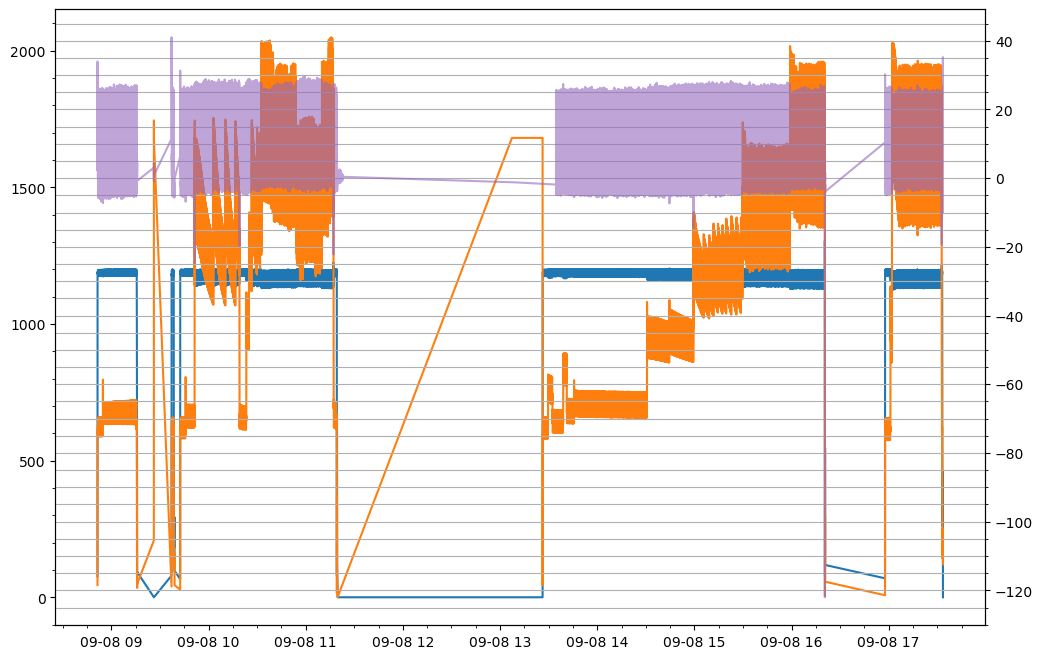

In [25]:
df_Plot = df_Data

fig, ax = plt.subplots(figsize=(12,8))

ax2 = ax.twinx()

ax.plot(df_Plot["ClockTime"], df_Plot["CVTSpeedIn"])
ax.plot(df_Plot["ClockTime"], df_Plot["PM RPM"])

ax2.plot(df_Plot["ClockTime"], df_Plot["ASD1 Out Torque"], color = "C4", alpha=0.6)

ax.minorticks_on()
ax2.minorticks_on()
#ax.grid(which="both")
ax2.grid(which="both")


## Load ML Model

In [26]:
# load the ML model created in "ASD_Predictive_Model.ipynb"
# input parameters are ASD input speed, ASD output speed, ASD Output Torque
IPT_Model = load(Model_Path + "ASD_Input_Torque_Model.joblib")
poly_converter = PolynomialFeatures(degree=2)

In [27]:
for df in d_df.values():
    X = df[["CVTSpeedIn","ASD1 Out Spd","ASD1 Out Trq"]]
    poly_features = poly_converter.fit_transform(X)
    df["Predicted ASD1 In Torque"] = IPT_Model.predict(poly_features)

### Motor Input and Output Power

In [28]:
for df in d_df.values():
    df["ASD1 Out Power"] = (df["ASD1 Out Trq"] * df["ASD1 Out Spd"] * .7457) / 5252
    df["ASD1 Out Energy"] = df["ASD1 Out Power"] * df["delta T"]

    df["Motor Output Power"] = (df["Predicted ASD1 In Torque"] * df["CVTSpeedIn"] * .7457) / 5252
    df["Motor Output Energy"] = (df["Motor Output Power"] * df["delta T"]).fillna(0)
    df["Motor Input Power"] = np.where(df["Motor Output Power"] > 0, \
        np.polynomial.polynomial.polyval(df["Motor Output Power"], p_in_coeffs),
        np.polynomial.polynomial.polyval(df["Motor Output Power"], p_in_coeffs_neg))
    df["Motor Input Energy"] = (df["Motor Input Power"] * df["delta T"]).fillna(0)

    df["Motor Output Power No Regen"] = np.where(df["Motor Output Power"]<0,0,df["Motor Output Power"])
    df["Motor Output Energy No Regen"] = (df["Motor Output Power No Regen"] * df["delta T"]).fillna(0)     
    df["Motor Input Power No Regen"] = np.polynomial.polynomial.polyval(df["Motor Output Power No Regen"], p_in_coeffs)
    df["Motor Input Energy No Regen"] = (df["Motor Input Power No Regen"] * df["delta T"]).fillna(0)

In [29]:
for df in d_df.values():
    # set real power to be the same as motor input power
    df["Sys Real Power"] = df["Motor Input Power"]
    df["Sys Real Energy"] = df["Sys Real Power"] * df["delta T"]

    df["Sys Real Power No Regen"] = df["Motor Input Power No Regen"]
    df["Sys Real Energy No Regen"] = df["Sys Real Power No Regen"] * df["delta T"]

    # set apparent power and energy to zero (for now)
    df["Sys App Power"] = 0
    df["Sys App Energy"] = 0

## Prepare Files for Export

### Aggregate by Stroke

In [30]:
# Create empty dictionaries to hold the data grouped and aggregated by stroke
d_df_Stroke = {}
d_df_AggStroke = {}

In [31]:
for key in d_df.keys():
    d_df_Stroke[key] = d_df[key].groupby(["StrokeNum"])

In [32]:
for key in d_df_Stroke.keys():
    d_df_AggStroke[key] = d_df_Stroke[key].agg(
        {
            "ClockTime":["min","max"],
            "SPM Calc":["mean"],
            "ASD Ratio":["mean"],
            "Sys App Power":["min","max"],
            "Sys App Energy":["sum"],
            "Sys Real Power":["min","max"],
            "Sys Real Energy":["sum"],
            "Motor Input Power":["min","max"],
            "Motor Input Energy":["sum"],
            "Motor Input Power No Regen":["min","max"],
            "Motor Input Energy No Regen":["sum"],
            "Motor Output Power":["min","max"],
            "Motor Output Energy":["sum"],
            "Motor Output Power No Regen":["min","max"],
            "Motor Output Energy No Regen":["sum"],
            "ASD1 Out Power":["min","max"],
            "ASD1 Out Energy":["sum"],
            "Prime Mover Sheave Power":["min","max"],
            "Prime Mover Sheave Energy":["sum"],
            "PR Power":["min","max"],
            "PR Energy":["sum"],
            "ASD1 Out Torque":["min","mean","max"],
            "GB Out Torq":["min","mean","max"],
            "GB In Torq":["min","mean","max"],
            "PM Trq":["min","mean","max"],
            "PM RPM":["min","mean","max"],
            "PR Load":["min","mean","max"],
            "CurrentPhaseL1":["min","mean","max"]
        }
    ).dropna()

    d_df_AggStroke[key] = d_df_AggStroke[key].sort_index()
    d_df_AggStroke[key].insert(2,"Stroke Time",(d_df_AggStroke[key][("ClockTime","max")]-d_df_AggStroke[key][("ClockTime","min")]).dt.total_seconds())
    ins_idx = d_df_AggStroke[key].columns.get_loc(("PR Power","max"))
    d_df_AggStroke[key].insert(ins_idx+1,("PR Power","Integrated"),0)

    # add in columns for stroke power which is the sum of stroke energy divided by stroke time
    for col in d_df_AggStroke[key].columns:
        if "Energy" in col[0]:
            if "No Regen" in col[0]:
                heading = " ".join(col[0].split(" ")[0:2] + col[0].split(" ")[3:]) + " Stroke Power"
            else:
                heading = " ".join(col[0].split(" ")[0:2]) + " Stroke Power"
            ins_idx = d_df_AggStroke[key].columns.get_loc(col)
            d_df_AggStroke[key].insert(ins_idx + 1, (heading,"tot"), d_df_AggStroke[key][col] / d_df_AggStroke[key]["Stroke Time"])

In [33]:
# for idx in df_AggStroke.index:
#     temp_group = df_Stroke.get_group(idx).dropna()

#     df_AggStroke.loc[idx,("PR Power","Integrated")] = \
#         (integrate.trapz(temp_group["PR Load"], x = temp_group["Position"]) * 0.113 / 1000) / \
#         df_AggStroke.loc[idx,"Stroke Time"]

In [34]:
# define bins to group the pumping rates
spm_bins = np.arange(0.25,10.75,.5)     # make the bins 0.5 SPM wide from .25 to 10.25
degree_bins = np.arange(0,361)          # make the bins 1 degree wide from 0 to 360

In [35]:
# flatten the column headers into a single level
for df in d_df_AggStroke.values():
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df["SPM Bin"] = pd.cut(df["SPM Calc mean"],bins=spm_bins)

In [36]:
for k, df in d_df_AggStroke.items():

    for idx in df.index:
        temp_group = d_df_Stroke[k].get_group(idx).dropna()

        df.loc[idx,("PR Power","Integrated")] = \
            (integrate.trapz(temp_group["PR Load"], x = temp_group["Position"]) * 0.113 / 1000) / \
            df.loc[idx,"Stroke Time"]

        temp_group["deg"] = pd.cut(temp_group["theta_shift"],degree_bins,include_lowest=True).apply(lambda x: x.left).astype("int")

        df.loc[idx,("GB In Torq Upstroke","max")] = \
            temp_group[temp_group["deg"].between(180,359)]["GB In Torq"].max()
        
        sys_app_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Sys App Power"].round(5).items()))
        df.loc[idx,("Sys App Power Stroke","coords")] = sys_app_pwr
        sys_real_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Sys Real Power"].round(5).items()))
        df.loc[idx,("Sys Real Power Stroke","coords")] = sys_real_pwr
        motor_input_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Motor Input Power"].round(5).items()))
        df.loc[idx,("Motor Input Power Stroke","coords")] = motor_input_pwr
        motor_output_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Motor Output Power"].round(5).items()))
        df.loc[idx,("Motor Output Power Stroke","coords")] = motor_output_pwr
        asd1_output_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["ASD1 Out Power"].round(5).items()))
        df.loc[idx,("ASD1 Output Power Stroke","coords")] = asd1_output_pwr
        pm_sheave_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Prime Mover Sheave Power"].round(5).items()))
        df.loc[idx,("Prime Mover Power Stroke","coords")] = pm_sheave_pwr
        pm_sheave_trq = str(list(temp_group.groupby("deg").mean().sort_index()["PM Trq"].round(5).items()))
        df.loc[idx,("Prime Mover Torque Stroke","coords")] = pm_sheave_trq
        gb_in_trq = str(list(temp_group.groupby("deg").mean().sort_index()["GB In Torq"].round(5).items()))
        df.loc[idx,("Gearbox Input Torque Stroke","coords")] = gb_in_trq
        rod_load = str(list(temp_group.groupby("deg").mean().sort_index()["PR Load"].round(5).items()))
        df.loc[idx,("Load Cell Stroke","coords")] = rod_load


### Plot PM Torque vs. Crank Angle

In [37]:
d_df_AggStroke[6].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1646 entries, 0.0 to 1647.0
Data columns (total 78 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ClockTime min                           1646 non-null   datetime64[ns]
 1   ClockTime max                           1646 non-null   datetime64[ns]
 2   Stroke Time                             1646 non-null   float64       
 3   SPM Calc mean                           1646 non-null   float64       
 4   ASD Ratio mean                          1646 non-null   float64       
 5   Sys App Power min                       1646 non-null   int64         
 6   Sys App Power max                       1646 non-null   int64         
 7   Sys App Energy sum                      1646 non-null   int64         
 8   Sys App Stroke Power tot                1646 non-null   float64       
 9   Sys Real Power min                      1646 n

In [38]:
d_df_AggStroke[6]["Prime Mover Torque Stroke"]

StrokeNum
0.0                                      [(358, -20.20738)]
1.0       [(1, 8.56664), (2, 9.19121), (3, 9.9856), (4, ...
2.0       [(0, 7.95731), (2, 9.00108), (3, 9.85122), (5,...
3.0       [(1, 8.19867), (2, 9.08261), (3, 10.26244), (5...
4.0       [(1, 8.35397), (2, 8.86605), (3, 9.53646), (4,...
                                ...                        
1643.0    [(4, 9.12934), (5, 12.13637), (10, 16.3107), (...
1644.0    [(3, 10.80987), (7, 13.94355), (12, 17.83481),...
1645.0    [(4, 11.52517), (9, 14.92972), (13, 18.655), (...
1646.0    [(4, 11.50739), (9, 14.75205), (13, 18.51763),...
1647.0    [(7, 13.47976), (12, 17.29886), (16, 21.04307)...
Name: Prime Mover Torque Stroke, Length: 1646, dtype: object

In [39]:
import ast

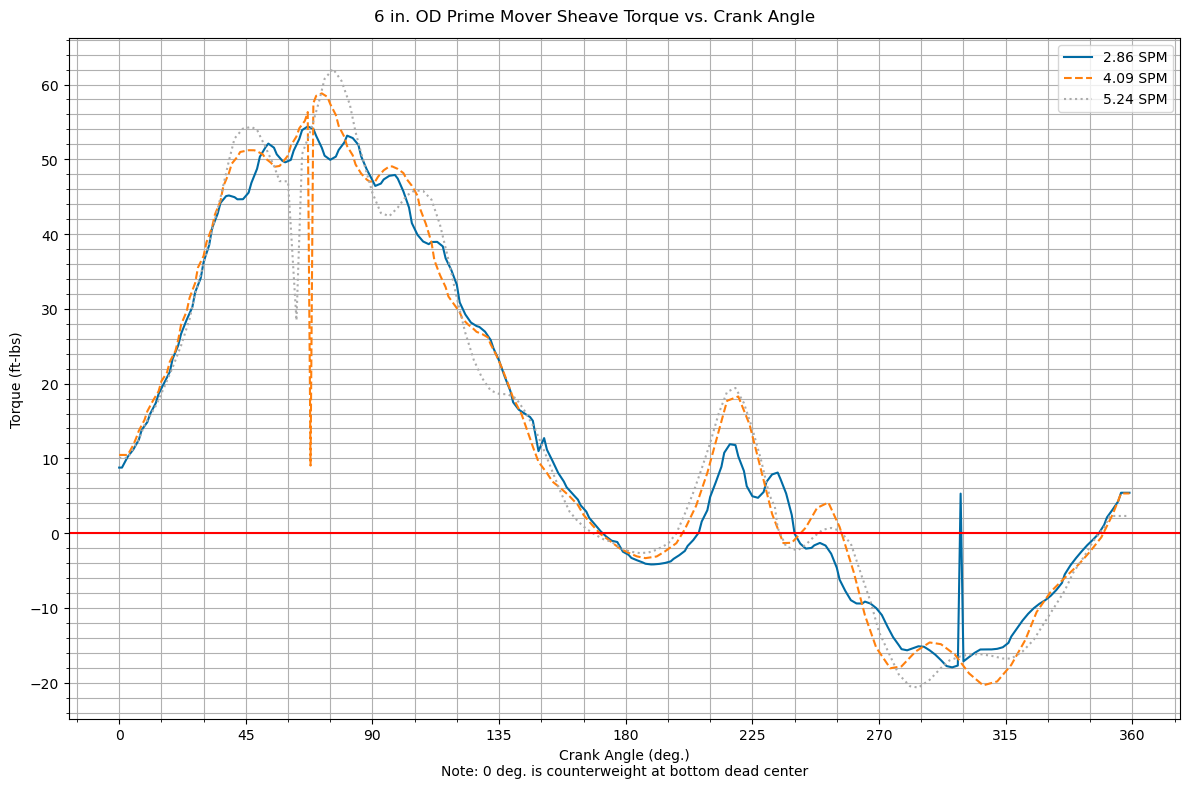

In [40]:
df_Temp = d_df_AggStroke[6].copy()

plt.style.use('tableau-colorblind10')

# Choose pumping rate range(s)
plot_Rates = [pd.Interval(2.75,3.25),pd.Interval(3.75,4.25),pd.Interval(4.75,5.25)]

# Set name of Measurement to Plot
msrmt = "Prime Mover Torque Stroke"

# Set number of strokes to average
start_Stroke = 10
num_Strokes = 50
linestyles = ["-","--",":","-.",(0,(1,5)),(0,(5,1)),(0,(3,1,1,1,1,1))]

fig,ax = plt.subplots(figsize=(12,8))

# Iterate through strokes in each pumping rate
for rate, ls in zip(plot_Rates, linestyles):
    xs = []
    ys = []
    SPM_List = []
    df_Plot = df_Temp[(df_Temp["SPM Bin"] == rate)]
    if df_Plot.shape[0] > start_Stroke + num_Strokes:
        strokes = list(df_Plot.index.unique())
        for s in strokes[start_Stroke:start_Stroke+num_Strokes]:
            SPM_List.append(df_Plot["SPM Calc mean"].values[0])
            coords = df_Plot[msrmt].values[0]
            coords = ast.literal_eval(coords)
            xs.append([c[0] for c in coords])
            ys.append([c[1] for c in coords])
        SPM = sum(SPM_List) / len(SPM_List)
        x_axis = np.arange(0,360)
        ys_interp = [np.interp(x_axis,xs[i], ys[i]) for i in range(len(xs))]
        mean_ys = np.mean(ys_interp, axis=0)
        label = f"{SPM:.2f} SPM"
        ax.plot(x_axis,mean_ys,label=label, linestyle=ls)
        #i = i + 1

ax.minorticks_on()
ax.xaxis.set_major_locator(ticker.MultipleLocator(45))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(15))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.grid(which="both")
ax.legend()
ax.axhline(0, color="red")
ax.set_ylabel("Torque (ft-lbs)")
ax.set_xlabel("Crank Angle (deg.)\nNote: 0 deg. is counterweight at bottom dead center")
fig.suptitle(f"6 in. OD Prime Mover Sheave Torque vs. Crank Angle")
fig.tight_layout()
#fig.savefig(Plot_Path+"Gearbox Input Torque vs Crank Angle (6-7SPM).jpg")

### Aggregate by Pump Rate

In [46]:
# Create empty dictionaries to hold the data grouped and aggregated by pumping rate
d_df_Rate = {}
d_df_AggRate = {}

In [47]:
for k in d_df.keys():
    d_df_Rate[k] = d_df_AggStroke[k].groupby(["SPM Bin"])

In [48]:
for k in d_df_Rate.keys():
    d_df_AggRate[k] = d_df_Rate[k].agg(
        {
            "SPM Calc mean":["count","mean"],
            "ASD Ratio mean":["mean"],
            "Motor Input No Regen Stroke Power tot":["mean","max"],
            "Motor Input Power No Regen max":["mean","max"],
            "Motor Output Stroke Power tot":["mean","max"],
            "Motor Output Power No Regen max":["mean","max"],
            "Prime Mover Stroke Power tot":["mean"],
            "PR Energy Stroke Power tot":["mean"]
        }
    )

    d_df_AggRate[k] = d_df_AggRate[k][d_df_AggRate[k]["SPM Calc mean","count"]>50]
    # df_AggRate = df_AggRate.reset_index().set_index(["Date","Series","PM Sheave Dia"])
    # df_AggRate.index.names = ["Date","Test Series","Sheave"]

In [49]:
# flatten and rename the columns
for k, df in d_df_AggRate.items():
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df.insert(0,"PM Sheave Dia",k)
    df.rename(columns={
            "SPM Calc mean count":"Num Strokes",
            "SPM Calc mean mean":"SPM",
            "ASD Ratio mean mean":"ASD Ratio",
            "Motor Input No Regen Stroke Power tot mean":"Motor per Stroke Input Power - Mean (kW)",
            "Motor Input No Regen Stroke Power tot max":"Motor per Stroke Input Power - Max (kW)",
            "Motor Input Power No Regen max mean":"Motor Peak Input Power - Mean (kW)",
            "Motor Input Power No Regen max max":"Motor Peak Input Power - Max (kW)",
            "Motor Output Stroke Power tot mean":"Motor per Stroke Output Power - Mean (kW)",
            "Motor Output Stroke Power tot max":"Motor per Stroke Output Power - Max (kW)",
            "Motor Output Power No Regen max mean":"Motor Peak Output Power - Mean (kW)",
            "Motor Output Power No Regen max max":"Motor Peak Output Power - Max (kW)",
            "Prime Mover Stroke Power tot mean":"Prime Mover Power - Mean (kW)",
            "PR Energy Stroke Power tot mean":"PR Power - Mean (kW)"
        },inplace=True)

In [50]:
# quick check to see what the data looks like
d_df_AggRate[6]

,PM Sheave Dia,Num Strokes,SPM,ASD Ratio,Motor per Stroke Input Power - Mean (kW),Motor per Stroke Input Power - Max (kW),Motor Peak Input Power - Mean (kW),Motor Peak Input Power - Max (kW),Motor per Stroke Output Power - Mean (kW),Motor per Stroke Output Power - Max (kW),Motor Peak Output Power - Mean (kW),Motor Peak Output Power - Max (kW),Prime Mover Power - Mean (kW),PR Power - Mean (kW)
SPM Bin,,,,,,,,,,,,,,
"(2.25, 2.75]",6,56,2.666480,2.045934,2.993900,22.252173,6.675178,7.190884,1.626830,4.086554,5.396652,5.862862,1.261246,0.969607
"(2.75, 3.25]",6,250,2.949189,2.256669,2.884114,3.191505,7.257909,8.689900,1.782085,2.030369,5.923692,7.224718,1.346633,1.073591
"(3.75, 4.25]",6,123,4.029462,3.093050,4.067399,4.596033,10.153914,14.669502,2.811220,3.360640,8.563030,12.722982,1.865496,1.485940
"(4.75, 5.25]",6,165,5.050707,3.890009,5.492058,6.417464,13.056245,20.204473,4.121787,4.742939,11.232815,17.835974,2.366418,1.879940
"(5.25, 5.75]",6,83,5.455063,4.205445,6.145908,6.733522,14.204594,15.169979,4.748307,5.359167,12.293317,13.185797,2.581920,2.048343
"(5.75, 6.25]",6,297,6.025076,4.657533,7.185659,7.678669,15.786757,16.890501,5.724896,6.280387,13.756308,14.777213,2.886451,2.283929
"(6.25, 6.75]",6,101,6.428059,4.972402,7.928279,8.680552,17.249610,19.125509,6.447153,7.113244,15.109052,16.841880,3.083801,2.443048
"(6.75, 7.25]",6,426,6.995060,5.428352,9.182088,9.789770,20.205646,21.936397,7.623000,8.176195,17.836053,19.425986,3.401313,2.666398
"(7.25, 7.75]",6,130,7.391954,5.745960,10.055247,10.982593,21.940803,23.387913,8.452231,9.295786,19.428819,20.751564,3.591883,2.821262


In [51]:
# combine both dataframes into a single dataframe
df_AggRate_Combined = pd.concat(d_df_AggRate.values())

In [52]:
df_AggRate_Combined.to_csv(Write_Path + "RPU15 predicted - Aggregated Data - Rate.csv")

### Aggregate by Date, Sheave Diameter, Pump Rate, and Stroke Number

In [38]:
df_RateStroke = df_Data_Exp.groupby(["Date","PM Sheave Dia","SPM Bin","StrokeNum"])

In [39]:
df_AggRateStroke = df_RateStroke.agg(
    {
        "SPM Calc":["mean"],
        "Sys App Power":["min","max"],
        "Sys App Energy":["sum"],
        "Sys Real Power":["min","max"],
        "Sys Real Energy":["sum"],
        "Motor Input Power":["min","max"],
        "Motor Input Energy":["sum"],
        "Motor Input Power No Regen":["min","max"],
        "Motor Input Energy No Regen":["sum"],
        "Motor Output Power":["min","max"],
        "Motor Output Energy":["sum"],
        "Motor Output Power No Regen":["min","max"],
        "Motor Output Energy No Regen":["sum"],
        "ASD1 Out Power":["min","max"],
        "ASD1 Out Energy":["sum"],
        "Prime Mover Sheave Power":["min","max"],
        "Prime Mover Sheave Energy":["sum"],
        "PR Power":["min","max"],
        "PR Energy":["sum"],
        "ASD1 Out Torque":["min","mean","max"],
        "GB Out Torq":["min","mean","max"],
        "GB In Torq":["min","mean","max"],
        "PM Trq":["min","mean","max"],
        "PM RPM":["min","mean","max"],
        "PR Load":["min","mean","max"],
        "CurrentPhaseL1":["min","mean","max"]
    }
).dropna()


In [40]:
df_AggRateStroke

SPM Calc Sys App Power      \
                                                     mean           min max   
Date       PM Sheave Dia SPM Bin      StrokeNum                               
2023-03-01 6.0           (0.75, 1.25] 1648.0     0.995751             0   0   
                         (2.25, 2.75] 0.0        1.813327             0   0   
                                      1.0        2.611510             0   0   
                                      2.0        2.640850             0   0   
                                      3.0        2.644579             0   0   
...                                                   ...           ...  ..   
                         (7.25, 7.75] 1615.0     7.295720             0   0   
                                      1622.0     7.267442             0   0   
                                      1629.0     7.281553             0   0   
                                      1636.0     7.281553             0   0   
                                      1643.0     7.267442             0   0   

                                                Sys App Energy Sys Real Power  \
                                                           sum            min   
Date       PM Sheave Dia SPM Bin      StrokeNum                                 
2023-03-01 6.0           (0.75, 1.25] 1648.0                 0      -0.296167   
                         (2.25, 2.75] 0.0                    0      -0.435451   
                                      1.0                    0      -1.684198   
                                      2.0                    0      -1.685442   
                                      3.0                    0      -1.689180   
...                                                        ...            ...   
                         (7.25, 7.75] 1615.0                 0       7.271872   
                                      1622.0                 0       7.276085   
                                      1629.0                 0       6.902182   
                                      1636.0                 0       5.864832   
                                      1643.0                 0       6.729509   

                                                           Sys Real Energy  \
                                                       max             sum   
Date       PM Sheave Dia SPM Bin      StrokeNum                              
2023-03-01 6.0           (0.75, 1.25] 1648.0     10.927596       81.256304   
                         (2.25, 2.75] 0.0        -0.435451       -0.043545   
                                      1.0         9.233882       69.916880   
                                      2.0         9.254783       69.652901   
                                      3.0         9.245339       69.648217   
...                                                    ...             ...   
                         (7.25, 7.75] 1615.0     30.049189       58.120828   
                                      1622.0     29.853346       57.910870   
                                      1629.0     29.546677       57.358002   
                                      1636.0     29.785015       58.580688   
                                      1643.0     30.632687       60.030188   

                                                Motor Input Power             \
                                                              min        max   
Date       PM Sheave Dia SPM Bin      StrokeNum                                
2023-03-01 6.0           (0.75, 1.25] 1648.0            -0.296167  10.927596   
                         (2.25, 2.75] 0.0               -0.435451  -0.435451   
                                      1.0               -1.684198   9.233882   
                                      2.0               -1.685442   9.254783   
                                      3.0               -1.689180   9.245339   
...                                                           ...        .

### Aggregate by Date, Sheave Diameter, and Stroke Number

In [41]:
df_Stroke = df_Data_Exp.groupby(["Date","PM Sheave Dia","StrokeNum"])

In [42]:
df_AggStroke = df_Stroke.agg(
    {
        "ClockTime":["min","max"],
        "SPM Calc":["mean"],
        "Sys App Power":["min","max"],
        "Sys App Energy":["sum"],
        "Sys Real Power":["min","max"],
        "Sys Real Energy":["sum"],
        "Motor Input Power":["min","max"],
        "Motor Input Energy":["sum"],
        "Motor Input Power No Regen":["min","max"],
        "Motor Input Energy No Regen":["sum"],
        "Motor Output Power":["min","max"],
        "Motor Output Energy":["sum"],
        "Motor Output Power No Regen":["min","max"],
        "Motor Output Energy No Regen":["sum"],
        "ASD1 Out Power":["min","max"],
        "ASD1 Out Energy":["sum"],
        "Prime Mover Sheave Power":["min","max"],
        "Prime Mover Sheave Energy":["sum"],
        "PR Power":["min","max"],
        "PR Energy":["sum"],
        "ASD1 Out Torque":["min","mean","max"],
        "GB Out Torq":["min","mean","max"],
        "GB In Torq":["min","mean","max"],
        "PM Trq":["min","mean","max"],
        "PM RPM":["min","mean","max"],
        "PR Load":["min","mean","max"],
        "CurrentPhaseL1":["min","mean","max"]
    }
).dropna()

df_AggStroke = df_AggStroke.sort_index()
df_AggStroke.insert(2,"Stroke Time",(df_AggStroke[("ClockTime","max")]-df_AggStroke[("ClockTime","min")]).dt.total_seconds())
ins_idx = df_AggStroke.columns.get_loc(("PR Power","max"))
df_AggStroke.insert(ins_idx+1,("PR Power","Integrated"),0)

# add in columns for stroke power which is the sum of stroke energy divided by stroke time
for col in df_AggStroke.columns:
    if "Energy" in col[0]:
        if "No Regen" in col[0]:
            heading = " ".join(col[0].split(" ")[0:2] + col[0].split(" ")[3:]) + " Stroke Power"
        else:
            heading = " ".join(col[0].split(" ")[0:2]) + " Stroke Power"
        ins_idx = df_AggStroke.columns.get_loc(col)
        df_AggStroke.insert(ins_idx + 1, (heading,"tot"), df_AggStroke[col] / df_AggStroke["Stroke Time"])

For each stroke,create an array or list of tuples that represent power vs. crank angle. First number in tuple is crank angle, second number is power or torque.

In [43]:
df_AggStroke.index

MultiIndex([('2023-03-01', 6.0,    0.0),
            ('2023-03-01', 6.0,    1.0),
            ('2023-03-01', 6.0,    2.0),
            ('2023-03-01', 6.0,    3.0),
            ('2023-03-01', 6.0,    4.0),
            ('2023-03-01', 6.0,    5.0),
            ('2023-03-01', 6.0,    6.0),
            ('2023-03-01', 6.0,    7.0),
            ('2023-03-01', 6.0,    8.0),
            ('2023-03-01', 6.0,    9.0),
            ...
            ('2023-03-01', 6.0, 1639.0),
            ('2023-03-01', 6.0, 1640.0),
            ('2023-03-01', 6.0, 1641.0),
            ('2023-03-01', 6.0, 1642.0),
            ('2023-03-01', 6.0, 1643.0),
            ('2023-03-01', 6.0, 1644.0),
            ('2023-03-01', 6.0, 1645.0),
            ('2023-03-01', 6.0, 1646.0),
            ('2023-03-01', 6.0, 1647.0),
            ('2023-03-01', 6.0, 1648.0)],
           names=['Date', 'PM Sheave Dia', 'StrokeNum'], length=1649)

In [44]:

degree_bins = np.arange(0,361)

for idx in df_AggStroke.index:
    temp_group = df_Stroke.get_group(idx).dropna()

    df_AggStroke.loc[idx,("PR Power","Integrated")] = \
        (integrate.trapz(temp_group["PR Load"], x = temp_group["Position"]) * 0.113 / 1000) / \
        df_AggStroke.loc[idx,"Stroke Time"]

    temp_group["deg"] = pd.cut(temp_group["theta_shift"],degree_bins,include_lowest=True).apply(lambda x: x.left).astype("int")

    df_AggStroke.loc[idx,("GB In Torq Upstroke","max")] = \
        temp_group[temp_group["deg"].between(180,359)]["GB In Torq"].max()
    
    sys_app_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Sys App Power"].round(5).items()))
    df_AggStroke.loc[idx,("Sys App Power Stroke","coords")] = sys_app_pwr
    sys_real_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Sys Real Power"].round(5).items()))
    df_AggStroke.loc[idx,("Sys Real Power Stroke","coords")] = sys_real_pwr
    motor_input_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Motor Input Power"].round(5).items()))
    df_AggStroke.loc[idx,("Motor Input Power Stroke","coords")] = motor_input_pwr
    motor_output_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Motor Output Power"].round(5).items()))
    df_AggStroke.loc[idx,("Motor Output Power Stroke","coords")] = motor_output_pwr
    asd1_output_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["ASD1 Out Power"].round(5).items()))
    df_AggStroke.loc[idx,("ASD1 Output Power Stroke","coords")] = asd1_output_pwr
    pm_sheave_pwr = str(list(temp_group.groupby("deg").mean().sort_index()["Prime Mover Sheave Power"].round(5).items()))
    df_AggStroke.loc[idx,("Prime Mover Power Stroke","coords")] = pm_sheave_pwr
    pm_sheave_trq = str(list(temp_group.groupby("deg").mean().sort_index()["PM Trq"].round(5).items()))
    df_AggStroke.loc[idx,("Prime Mover Torque Stroke","coords")] = pm_sheave_trq
    gb_in_trq = str(list(temp_group.groupby("deg").mean().sort_index()["GB In Torq"].round(5).items()))
    df_AggStroke.loc[idx,("Gearbox Input Torque Stroke","coords")] = gb_in_trq
    rod_load = str(list(temp_group.groupby("deg").mean().sort_index()["PR Load"].round(5).items()))
    df_AggStroke.loc[idx,("Load Cell Stroke","coords")] = rod_load


In [45]:
df_AggStroke.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1649 entries, (Timestamp('2023-03-01 00:00:00'), 6.0, 0.0) to (Timestamp('2023-03-01 00:00:00'), 6.0, 1648.0)
Data columns (total 72 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   (ClockTime, min)                           1649 non-null   datetime64[ns]
 1   (ClockTime, max)                           1649 non-null   datetime64[ns]
 2   (Stroke Time, )                            1649 non-null   float64       
 3   (SPM Calc, mean)                           1649 non-null   float64       
 4   (Sys App Power, min)                       1649 non-null   int64         
 5   (Sys App Power, max)                       1649 non-null   int64         
 6   (Sys App Energy, sum)                      1649 non-null   int64         
 7   (Sys App Stroke Power, tot)                1649 non-null   float64       
 8   (Sys Real Po

In [46]:
df_AggStroke

ClockTime  \
                                                       min   
Date       PM Sheave Dia StrokeNum                           
2023-03-01 6.0           0.0       2022-09-08 08:51:25.800   
                         1.0       2022-09-08 08:51:27.000   
                         2.0       2022-09-08 08:51:50.000   
                         3.0       2022-09-08 08:52:12.700   
                         4.0       2022-09-08 08:52:35.400   
...                                                    ...   
                         1644.0    2022-09-08 17:32:11.800   
                         1645.0    2022-09-08 17:32:20.100   
                         1646.0    2022-09-08 17:32:28.500   
                         1647.0    2022-09-08 17:32:37.100   
                         1648.0    2022-09-08 17:32:47.900   

                                                           Stroke Time  \
                                                       max               
Date       PM Sheave Dia StrokeNum                                       
2023-03-01 6.0           0.0       2022-09-08 08:51:26.900         1.1   
                         1.0       2022-09-08 08:51:49.900        22.9   
                         2.0       2022-09-08 08:52:12.600        22.6   
                         3.0       2022-09-08 08:52:35.300        22.6   
                         4.0       2022-09-08 08:52:58.000        22.6   
...                                                    ...         ...   
                         1644.0    2022-09-08 17:32:15.100         3.3   
                         1645.0    2022-09-08 17:32:25.100         5.0   
                         1646.0    2022-09-08 17:32:33.800         5.3   
                         1647.0    2022-09-08 17:32:47.800        10.7   
                         1648.0    2022-09-08 17:33:25.700        37.8   

                                    SPM Calc Sys App Power     Sys App Energy  \
                                        mean           min max            sum   
Date       PM Sheave Dia StrokeNum                                              
2023-03-01 6.0           0.0        0.340171             0   0              0   
                         1.0        2.611510             0   0              0   
                         2.0        2.640850             0   0              0   
                         3.0        2.644579             0   0              0   
                         4.0        2.650141             0   0              0   
...                                      ...           ...  ..            ...   
                         1644.0     7.183908             0   0              0   
                         1645.0     7.075472             0   0              0   
                         1646.0     6.970260             0   0              0   
                         1647.0     5.161094             0   0              0   
                         1648.0     0.995751             0   0              0   

                                   Sys App Stroke Power Sys Real Power  \
                                                    tot            min   
Date       PM Sheave Dia StrokeNum                                       
2023-03-01 6.0           0.0                        0.0      -0.435451   
                         1.0                        0.0      -1.684198   
                         2.0                        0.0      -1.685442   
                         3.0                        0.0      -1.689180   
                         4.0                        0.0      -1.759313   
...                                                 ...            ...   
                         1644.0                     0.0       4.427429   
                         1645.0                     0.0       2.926320   
                         1646.0                     0.0       2.784818   
                         1647.0                     0.0      -3.193020   
                         1648.0               

## Write Data to Files

In [36]:
# strDate = datetime.strftime(Test_Date,"%Y-%m-%d")
# df_AggStroke.loc[(strDate,6,10),("Motor Output Stroke Power","tot")]

In [49]:
# 1/6/23 - Note: File Names Changed Based on Belt Pulley Ratio
# df_Data.to_csv(Write_Path + "Series E3 Test Data - All.csv")
# df_AggRateStroke.to_csv(Write_Path + "RPU15 9in sheave predicted - Aggregated Data - Rate and Stroke.csv")
#df_AggStroke.to_csv(Write_Path + "RPU15 9in sheave predicted - Aggregated Data - Stroke.csv")

In [38]:
# df_Data.to_csv(Write_Path + Test_Name + " Test Data - All.csv")
# df_AggRateStroke.to_csv(Write_Path + Test_Name + " Aggregated Data - Rate and Stroke.csv")
# df_AggStroke.to_csv(Write_Path + Test_Name + " Aggregated Data - Stroke.csv")

## End of Notebook - Test Area Below this Point

In [291]:
df_AggStroke.index

MultiIndex([('2022-09-13', 6,   1),
            ('2022-09-13', 6,   2),
            ('2022-09-13', 6,   3),
            ('2022-09-13', 6,   4),
            ('2022-09-13', 6,   5),
            ('2022-09-13', 6,   6),
            ('2022-09-13', 6,   7),
            ('2022-09-13', 6,   8),
            ('2022-09-13', 6,   9),
            ('2022-09-13', 6,  10),
            ...
            ('2022-09-13', 6, 662),
            ('2022-09-13', 6, 663),
            ('2022-09-13', 6, 664),
            ('2022-09-13', 6, 665),
            ('2022-09-13', 6, 666),
            ('2022-09-13', 6, 667),
            ('2022-09-13', 6, 668),
            ('2022-09-13', 6, 669),
            ('2022-09-13', 6, 670),
            ('2022-09-13', 6, 671)],
           names=['Date', 'PM Sheave Dia', 'StrokeNum'], length=671)

In [292]:
idx = ('2022-09-13', 6,   6)
df_Stroke.get_group(idx)[["ClockTime","delta T","Sys App Energy"]]

,ClockTime,delta T,Sys App Energy
15464,2022-09-13 10:34:20.840000,0.009116,0.078990
15465,2022-09-13 10:34:20.845903,0.005903,0.051054
15466,2022-09-13 10:34:20.856000,0.010097,0.087049
15467,2022-09-13 10:34:20.860964,0.004964,0.042794
15468,2022-09-13 10:34:20.872000,0.011036,0.095129
...,...,...,...
18481,2022-09-13 10:34:44.215966,0.015019,0.129585
18482,2022-09-13 10:34:44.216000,0.000034,0.000293
18483,2022-09-13 10:34:44.230984,0.014984,0.129905
18484,2022-09-13 10:34:44.232000,0.001016,0.008811
